In [1]:
pip install opencv-python scikit-learn matplotlib tqdm

In [2]:
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [3]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
import numpy as np

def load_cifar100_torch(n_samples=10000):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)

    X, y = [], []
    for i in range(n_samples):
        img, label = dataset[i]
        img = img.numpy().transpose(1, 2, 0) * 255
        X.append(img.astype(np.uint8))
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [4]:
# Resize image and convert to grayscale
def preprocess_image(img, size=(128, 128)):
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

In [5]:
# Extract ORB and HOG features
def extract_features(img):
    # ORB descriptors
    orb = cv2.ORB_create(nfeatures=200)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    if descriptors is None:
        descriptors = np.zeros((1, 32))  # fallback
    return descriptors

In [6]:
# Extract HOG descriptors
def extract_hog(img):
    hog = cv2.HOGDescriptor()
    h = hog.compute(img)
    return h.flatten()

In [7]:
# Create BoVW feature vector
def compute_bovw(descriptor_list, k=100):
    all_descriptors = np.vstack(descriptor_list)
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=k*3)
    kmeans.fit(all_descriptors)
    bovw_features = []
    for desc in descriptor_list:
        words = kmeans.predict(desc)
        hist, _ = np.histogram(words, bins=np.arange(k+1))
        bovw_features.append(hist)
    return np.array(bovw_features), kmeans

In [ ]:
def run_pipeline():
    X, y = load_cifar100_torch(n_samples=10000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    orb_descriptors_train = []
    hog_features_train = []

    print("Extracting features from training images...")
    for img in tqdm(X_train):
        gray = preprocess_image(img)
        orb_desc = extract_features(gray)
        hog_feat = extract_hog(gray)
        orb_descriptors_train.append(orb_desc)
        hog_features_train.append(hog_feat)

    print("Building Bag of Visual Words...")
    bovw_train, kmeans = compute_bovw(orb_descriptors_train, k=100)

    # Combine BoVW and HOG features
    hog_features_train = np.array(hog_features_train)
    combined_train = np.hstack((bovw_train, hog_features_train))

    # Scale features
    scaler = StandardScaler()
    combined_train = scaler.fit_transform(combined_train)


    print("Hyperparameter tuning using GridSearchCV...")

    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']  # only used with 'rbf'
    }

    svc = SVC(probability=True)  # Needed for PR curve

    grid_search = GridSearchCV(
        estimator=svc,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(combined_train, y_train)
    clf = grid_search.best_estimator_

    print("Best Parameters:", grid_search.best_params_)
    print("Best CV Score:", grid_search.best_score_)


    # ---- TESTING ----
    print("Extracting features from test images...")
    orb_descriptors_test = []
    hog_features_test = []
    for img in tqdm(X_test):
        gray = preprocess_image(img)
        orb_desc = extract_features(gray)
        hog_feat = extract_hog(gray)
        orb_descriptors_test.append(orb_desc)
        hog_features_test.append(hog_feat)

    bovw_test = []
    for desc in orb_descriptors_test:
        words = kmeans.predict(desc)
        hist, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1))
        bovw_test.append(hist)
    bovw_test = np.array(bovw_test)

    hog_features_test = np.array(hog_features_test)
    combined_test = np.hstack((bovw_test, hog_features_test))
    combined_test = scaler.transform(combined_test)

    print("Evaluating...")
    y_pred = clf.predict(combined_test)
    print(classification_report(y_test, y_pred))

    return y_train, y_test, y_pred, clf, combined_test, grid_search # for further plotting


In [9]:
y_test, y_pred, clf, combined_test, grid_search = run_pipeline()

100%|██████████| 169M/169M [00:03<00:00, 48.7MB/s]


Extracting features from training images...


100%|██████████| 8000/8000 [00:10<00:00, 785.18it/s]


Building Bag of Visual Words...
Training SVM...
Extracting features from test images...


100%|██████████| 2000/2000 [00:02<00:00, 968.08it/s]


Evaluating...
              precision    recall  f1-score   support

           0       0.32      0.27      0.29        22
           1       0.08      0.08      0.08        13
           2       0.05      0.07      0.06        15
           3       0.09      0.06      0.07        17
           4       0.04      0.05      0.04        22
           5       0.21      0.15      0.18        26
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        24
           8       0.32      0.52      0.40        23
           9       0.34      0.62      0.44        16
          10       0.18      0.24      0.20        21
          11       0.05      0.05      0.05        19
          12       0.21      0.11      0.14        28
          13       0.10      0.06      0.07        17
          14       0.00      0.00      0.00        18
          15       0.00      0.00      0.00        20
          16       0.17      0.20      0.19        20
          17 

In [18]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_model_evaluation(y_test, y_pred, clf, combined_test):
    classes_to_plot = list(range(10))  # Limit to first 10 classes
    num_classes = len(np.unique(y_test))

    # --- Confusion Matrix ---
    conf_matrix = confusion_matrix(y_test, y_pred, labels=classes_to_plot)
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes_to_plot).plot(ax=ax1)
    plt.title("Confusion Matrix (Top 10 Classes)")
    plt.tight_layout()

    # --- Accuracy Heatmap ---
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=classes_to_plot, yticklabels=classes_to_plot)
    ax2.set_title("Accuracy Heatmap (Top 10 Classes)")
    ax2.set_xlabel("Predicted Label")
    ax2.set_ylabel("True Label")
    plt.tight_layout()

    # --- Precision-Recall Curve ---
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(combined_test)
        y_test_bin = label_binarize(y_test, classes=range(num_classes))

        fig3, ax3 = plt.subplots(figsize=(10, 8))
        for i in classes_to_plot:
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ax3.plot(recall, precision, label=f"Class {i}")
        ax3.set_title("Precision-Recall Curves (Top 10 Classes)")
        ax3.set_xlabel("Recall")
        ax3.set_ylabel("Precision")
        ax3.legend(loc="best")
        plt.tight_layout()

    # --- Precision, Recall, F1 Score Matrix ---
    print("\nGenerating Precision-Recall-F1 Matrix (Top 10 Classes)...")
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).T.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")

    # Filter only the top 10 classes (0–9 as strings)
    report_df = report_df.loc[[str(i) for i in classes_to_plot]]

    fig4, ax4 = plt.subplots(figsize=(12, 4))
    sns.heatmap(report_df[["precision", "recall", "f1-score"]].astype(float),
                annot=True, fmt=".2f", cmap="Blues", ax=ax4)
    ax4.set_title("Precision, Recall, F1-score (Top 10 Classes)")
    ax4.set_xlabel("Metric")
    ax4.set_ylabel("Class")
    plt.tight_layout()

    plt.show()



Generating Precision-Recall-F1 Matrix (Top 10 Classes)...


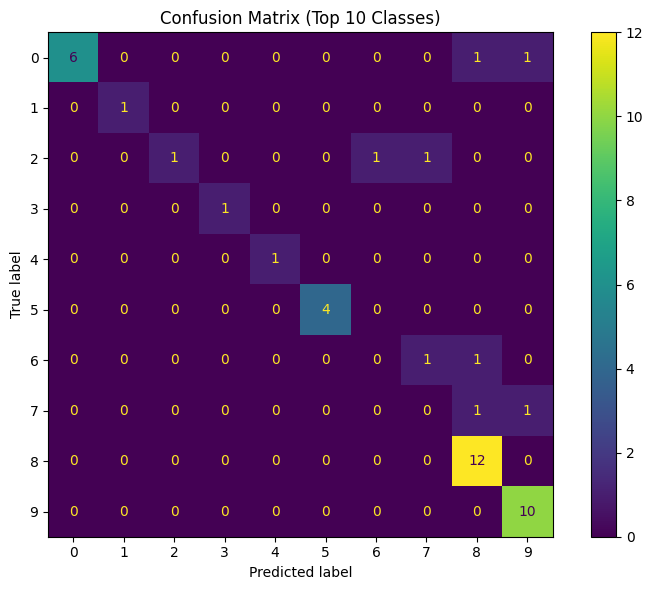

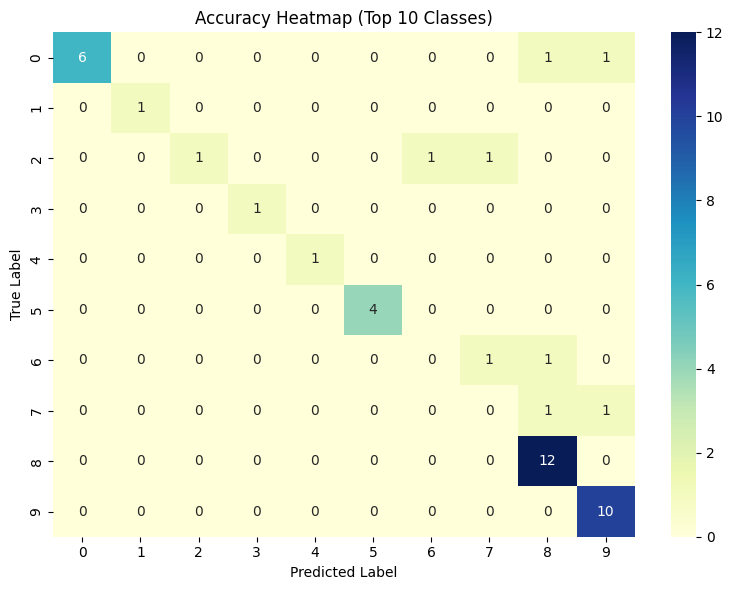

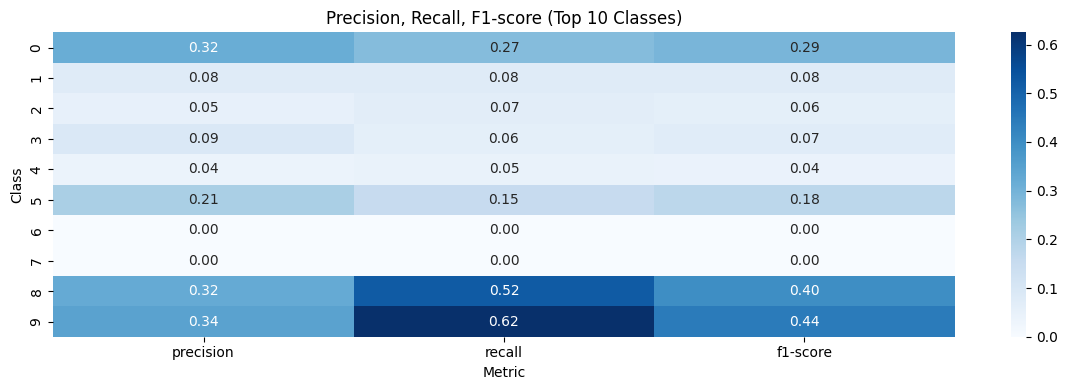

In [19]:
plot_model_evaluation(y_test, y_pred, clf, combined_test)

In [ ]:
def plot_hyperparameter_results(grid_search):
    print("\nBest Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    results = pd.DataFrame(grid_search.cv_results_)

    if 'param_C' in results.columns and 'param_kernel' in results.columns:
        pivot = results.pivot(index="param_C", columns="param_kernel", values="mean_test_score")

        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
        plt.title("GridSearchCV Mean Test Score")
        plt.xlabel("Kernel")
        plt.ylabel("C")
        plt.tight_layout()
        plt.show()
    else:
        print("Unable to plot hyperparameter grid. Only 1D search space or missing parameters.")


In [ ]:
plot_hyperparameter_results(grid_search)